In [1]:
import math
import numpy as np
import glob as gb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

In [2]:
print('Ilosc danych w bazie: 10 000')
print('Rozmiar obrazow w bazie: 400x400')

X = []
y = []

# dokonanie zmian w strukturze obrazow - skala szarosci oraz ujednolicenie rozmiaru
for folder in  os.listdir('./images') : 
    files = gb.glob(pathname= str('./images' + '/' + folder + '/*.jpg'))
    for file in files:
        image =  imread(file, as_gray=True)
        resized_image = resize(image, (100,100))
        X.append(resized_image)
        y.append(folder)

Ilosc danych w bazie: 10 000
Rozmiar obrazow w bazie: 400x400


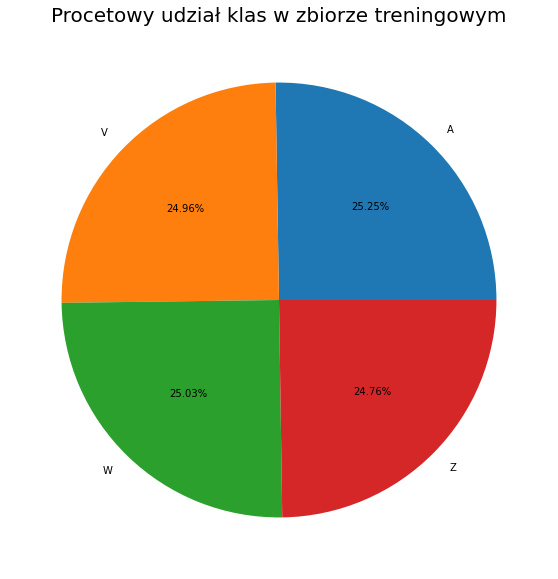

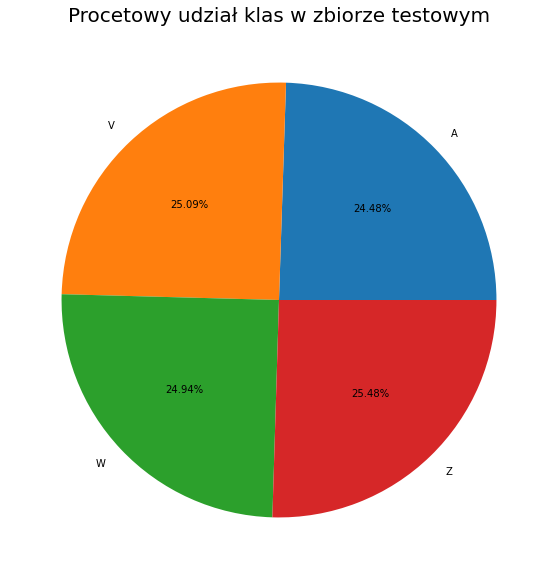

{0: 'A', 1: 'V', 2: 'W', 3: 'Z'}

In [3]:
# podzial na zbior treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# przetestowanie zbioru treningowego
X_train, y_train = shuffle(X_train, y_train)

X_train = np.array(X_train)
X_test = np.array(X_test)

(unique_train, counts_train) = np.unique(y_train, return_counts=True)
frequencies_train = np.asarray((unique_train, counts_train*100/len(y_train))).T

(unique_test, counts_test) = np.unique(y_test, return_counts=True)
frequencies_test = np.asarray((unique_test, counts_test*100/len(y_test))).T

def bar_chart(l, s):
    labels = []
    data = []
    for i in l:
        labels.append(i[0])
        data.append(float(i[1]))
    plt.figure(figsize = (30,10))
    plt.pie(data, labels = labels, autopct='%1.2f%%')
    plt.title("Procetowy udział klas w zbiorze " + s, fontsize=20)
    plt.show()

# ustalenie procentowych udzialow poszczegolnych klas w zbiorze trningowym i testowym
bar_chart(frequencies_train, "treningowym")
bar_chart(frequencies_test, "testowym")

# ustalenie liczby klas i przydzielenie etykiet
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

labelsEncoded = {}
for i in range(0, 4):
    labelsEncoded[i] = le.inverse_transform([i])[0]
labelsEncoded

Epoch 1/10
141/141 [==============================] - 2s 8ms/step - loss: 0.9888 - accuracy: 0.6105 - val_loss: 0.7022 - val_accuracy: 0.7437
Epoch 2/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5934 - accuracy: 0.7696 - val_loss: 0.4591 - val_accuracy: 0.8504
Epoch 3/10
141/141 [==============================] - 1s 6ms/step - loss: 0.4247 - accuracy: 0.8471 - val_loss: 0.3911 - val_accuracy: 0.8454
Epoch 4/10
141/141 [==============================] - 1s 7ms/step - loss: 0.2962 - accuracy: 0.9147 - val_loss: 0.2753 - val_accuracy: 0.8870
Epoch 5/10
141/141 [==============================] - 1s 7ms/step - loss: 0.2687 - accuracy: 0.9100 - val_loss: 0.1862 - val_accuracy: 0.9498
Epoch 6/10
141/141 [==============================] - 1s 7ms/step - loss: 0.2606 - accuracy: 0.8986 - val_loss: 0.1674 - val_accuracy: 0.9539
Epoch 7/10
141/141 [==============================] - 1s 8ms/step - loss: 0.1611 - accuracy: 0.9454 - val_loss: 0.1392 - val_accuracy: 0.9354
Epoch 

<AxesSubplot:>

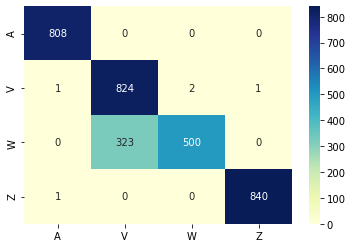

In [4]:
# przygotowanie modelu sztucznej sieci neuronowej
model = Sequential()

model.add(Flatten(input_shape=(100, 100)))
model.add(Dense(128, activation='relu', name='fc1'))
model.add(Dense(64, activation='relu', name='fc2'))
model.add(Dense(4, activation='softmax', name='output'))

# kompilacja modelu z odpowiednia funkcja straty
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# trenowanie modelu na zbiorze treningowym
history = model.fit(X_train, y_train, validation_split=0.33, epochs=10, callbacks=[tensorboard_callback])
result = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# ocena modelu a zbiorze treningowym
print('\n\nStrata: ', result[0])
print('Dokladnosc: ', result[1])

# macierz bledu
y_labels = ['A', 'V', 'W', 'Z']
pred_labels = np.argmax(predictions, axis = 1)
m = metrics.confusion_matrix(y_test, pred_labels)
sn.heatmap(m, annot=True, fmt="d", cmap="YlGnBu", xticklabels=y_labels, yticklabels=y_labels)

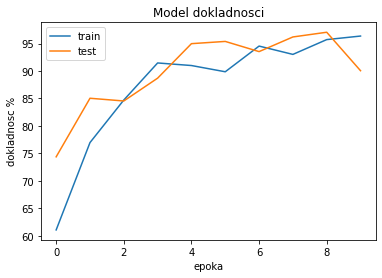

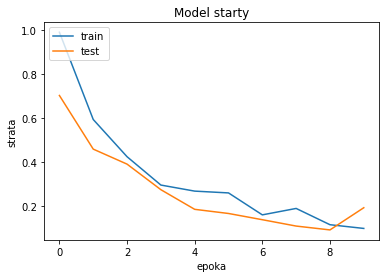

In [5]:
history.history['accuracy'] = np.array(history.history['accuracy'])*100
history.history['val_accuracy'] = np.array(history.history['val_accuracy'])*100

# wykres przedstawiajacy dokladnosc modelu na zbiorze treningowym i walidacyjnym w kolejnych epokach
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model dokladnosci')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# wykres przedstawiajacy strate modelu na zbiorze treningowym i walidacyjnym w kolejnych epokach
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model starty')
plt.ylabel('strata')
plt.xlabel('epoka')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

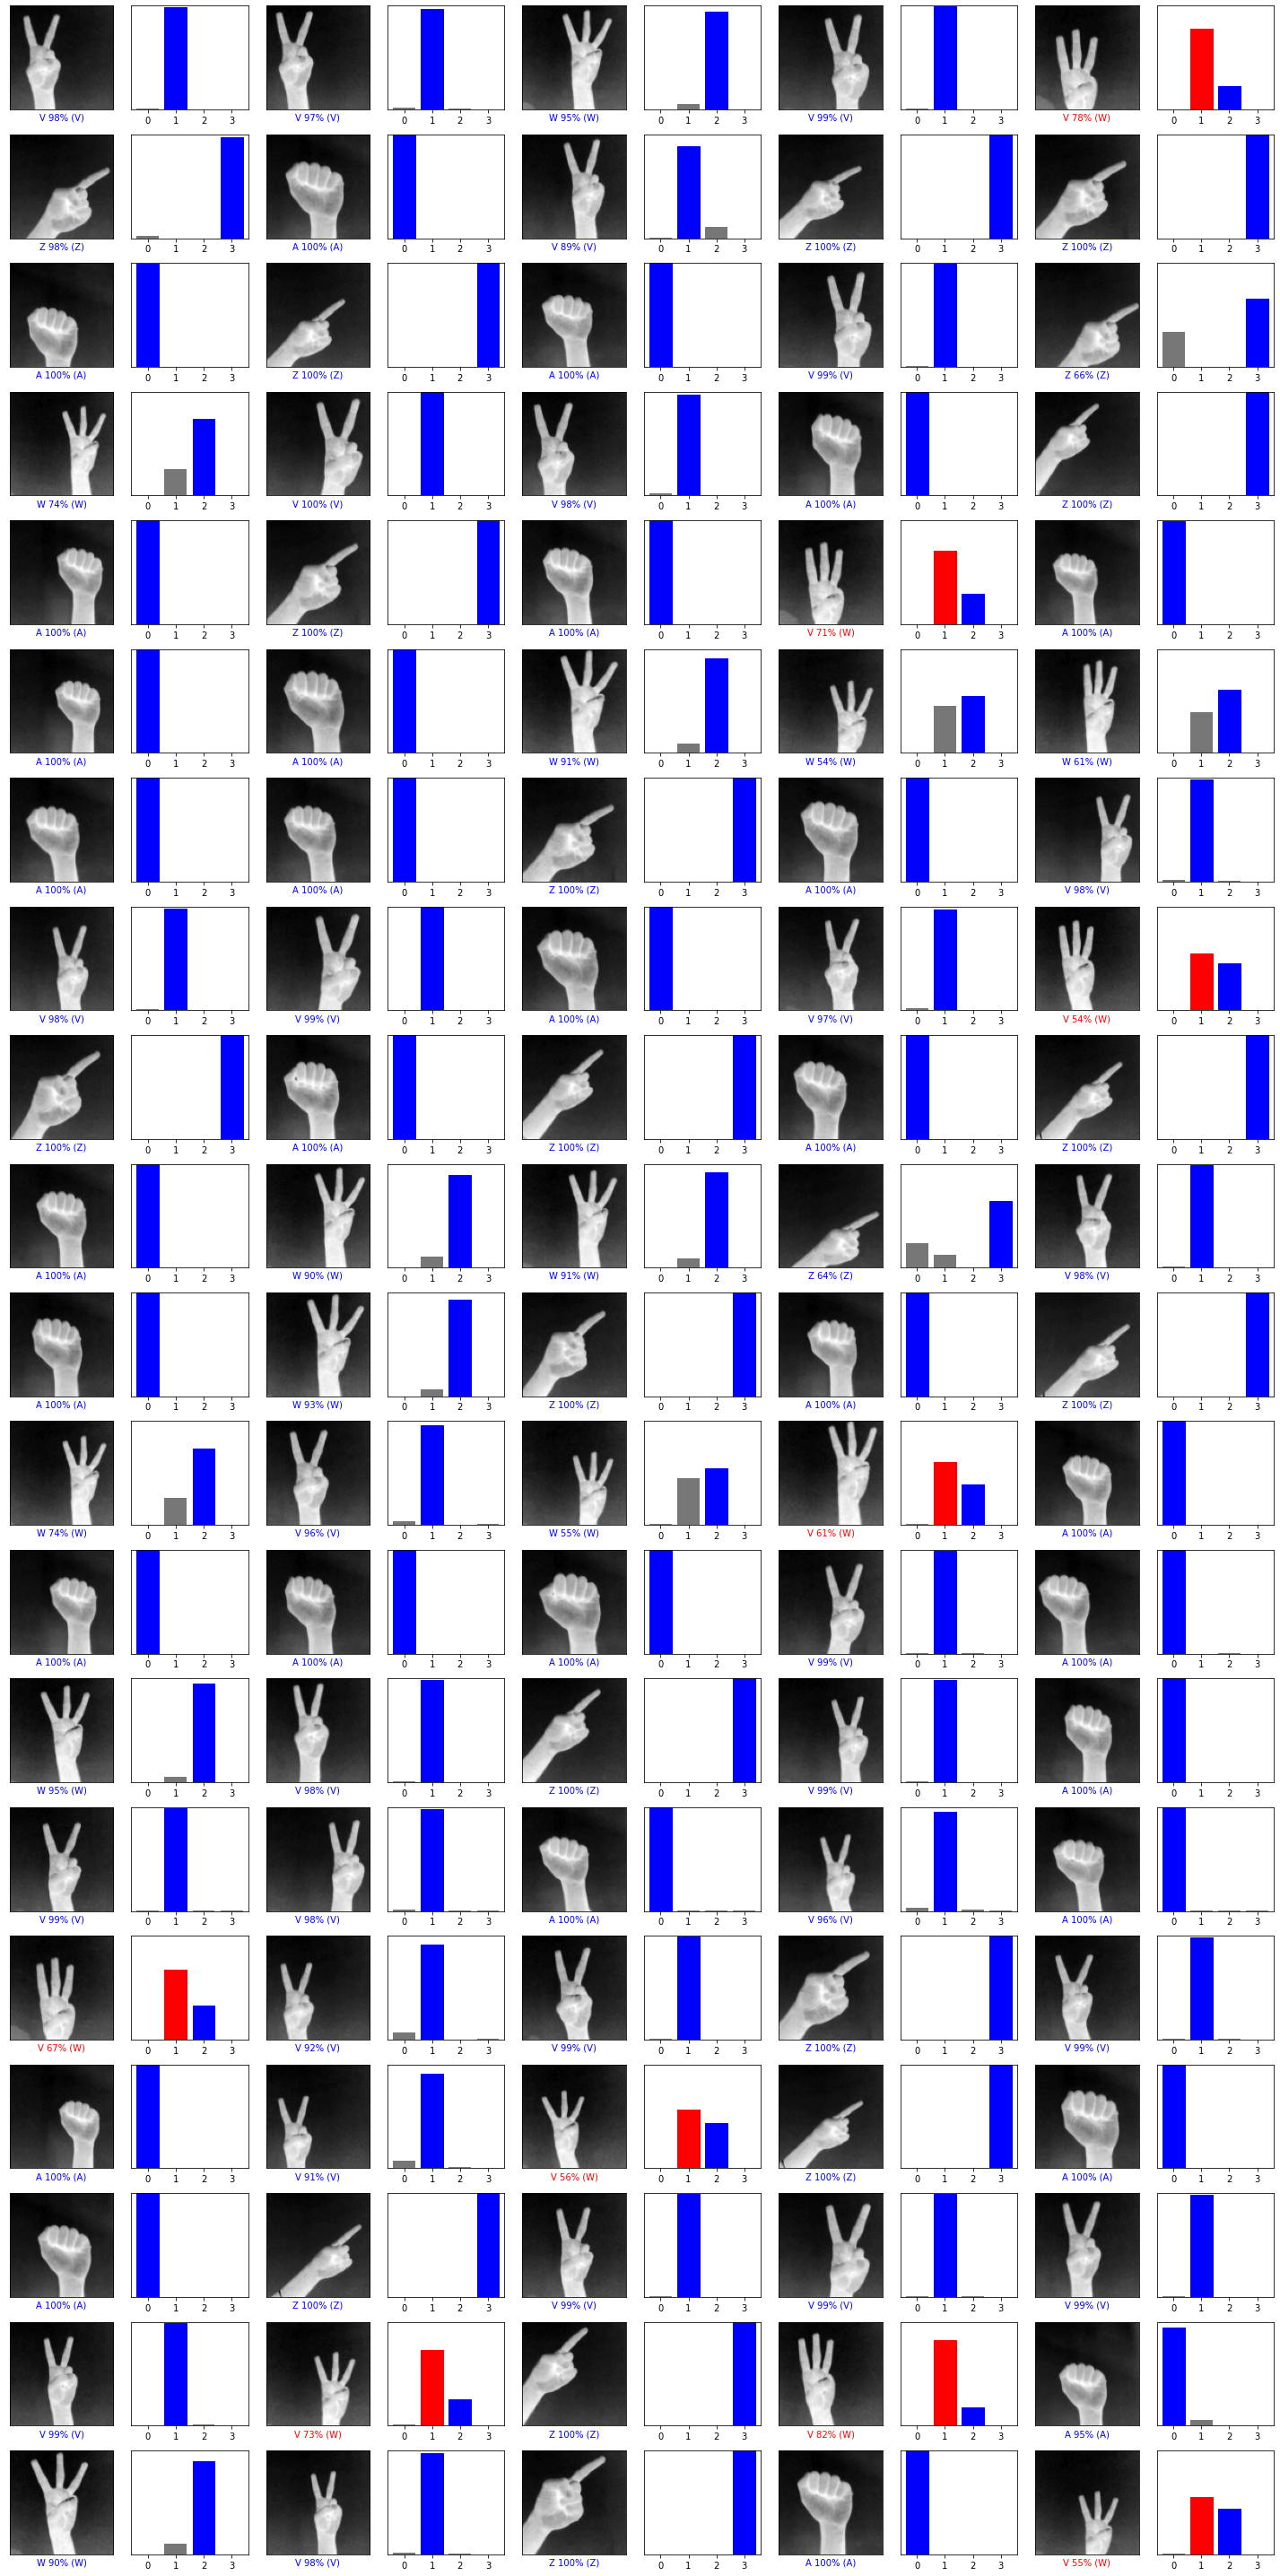

In [6]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(labelsEncoded[predicted_label],
                                100*np.max(predictions_array),
                                labelsEncoded[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
    
# rozklady prawdopodobienstwa klas dla 100 przykladowych rekordow
num_rows = 20
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.savefig('predictions')
plt.show()

In [7]:
%load_ext tensorboard

In [18]:
%reload_ext tensorboard
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 14456), started 2:43:21 ago. (Use '!kill 14456' to kill it.)

Epoch 1/10
141/141 [==============================] - 1s 7ms/step - loss: 1.4087 - accuracy: 0.2489 - val_loss: 1.3911 - val_accuracy: 0.2500
Epoch 2/10
141/141 [==============================] - 1s 6ms/step - loss: 1.3953 - accuracy: 0.2525 - val_loss: 1.3911 - val_accuracy: 0.2491
Epoch 3/10
141/141 [==============================] - 1s 7ms/step - loss: 1.3924 - accuracy: 0.2491 - val_loss: 1.3883 - val_accuracy: 0.2505
Epoch 4/10
141/141 [==============================] - 1s 6ms/step - loss: 1.3933 - accuracy: 0.2455 - val_loss: 1.3871 - val_accuracy: 0.2505
Epoch 5/10
141/141 [==============================] - 1s 6ms/step - loss: 1.3907 - accuracy: 0.2451 - val_loss: 1.3892 - val_accuracy: 0.2505
Epoch 6/10
141/141 [==============================] - 1s 6ms/step - loss: 1.3901 - accuracy: 0.2516 - val_loss: 1.3893 - val_accuracy: 0.2500
Epoch 7/10
141/141 [==============================] - 1s 6ms/step - loss: 1.3906 - accuracy: 0.2373 - val_loss: 1.3873 - val_accuracy: 0.2505
Epoch 

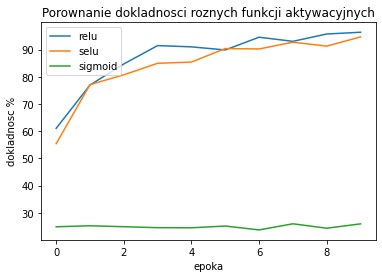

In [9]:
model_sigmoid = Sequential()
model_sigmoid.add(Flatten(input_shape=(100, 100)))
model_sigmoid.add(Dense(128, activation='sigmoid', name='fc1'))
model_sigmoid.add(Dense(64, activation='sigmoid', name='fc2'))
model_sigmoid.add(Dense(4, activation='softmax', name='output'))
model_sigmoid.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_sigmoid = model_sigmoid.fit(X_train, y_train, validation_split=0.33, epochs=10)
result_sigmoid = model_sigmoid.evaluate(X_test, y_test)

print('\n\nDokladnosc dla funkcji "sigmoid": ', result_sigmoid[1], '\n\n')


model_selu = Sequential()
model_selu.add(Flatten(input_shape=(100, 100)))
model_selu.add(Dense(128, activation='selu', name='fc1'))
model_selu.add(Dense(64, activation='selu', name='fc2'))
model_selu.add(Dense(4, activation='softmax', name='output'))
model_selu.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_selu = model_selu.fit(X_train, y_train, validation_split=0.33, epochs=10)
result_selu = model_selu.evaluate(X_test, y_test)

print('\n\nDokladnosc dla funkcji "selu": ', result_selu[1], '\n\n')


# porownanie dokladnosci roznych funkcji aktywacyjnych
history_selu.history['accuracy'] = np.array(history_selu.history['accuracy'])*100
history_sigmoid.history['accuracy'] = np.array(history_sigmoid.history['accuracy'])*100

plt.plot(history.history['accuracy'])
plt.plot(history_selu.history['accuracy'])
plt.plot(history_sigmoid.history['accuracy'])
plt.title('Porownanie dokladnosci roznych funkcji aktywacyjnych')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['relu', 'selu', 'sigmoid'], loc='upper left')
plt.show()

Epoch 1/20
141/141 [==============================] - 2s 13ms/step - loss: 2.3337 - accuracy: 0.5611 - val_loss: 0.9736 - val_accuracy: 0.6614
Epoch 2/20
141/141 [==============================] - 1s 6ms/step - loss: 0.6002 - accuracy: 0.7765 - val_loss: 0.6404 - val_accuracy: 0.7342
Epoch 3/20
141/141 [==============================] - 1s 7ms/step - loss: 0.4541 - accuracy: 0.8458 - val_loss: 0.3954 - val_accuracy: 0.9033
Epoch 4/20
141/141 [==============================] - 1s 6ms/step - loss: 0.3641 - accuracy: 0.8935 - val_loss: 0.3187 - val_accuracy: 0.9281
Epoch 5/20
141/141 [==============================] - 1s 6ms/step - loss: 0.3222 - accuracy: 0.8993 - val_loss: 0.4980 - val_accuracy: 0.7816
Epoch 6/20
141/141 [==============================] - 1s 6ms/step - loss: 0.2893 - accuracy: 0.9037 - val_loss: 0.4224 - val_accuracy: 0.8146
Epoch 7/20
141/141 [==============================] - 1s 6ms/step - loss: 0.2405 - accuracy: 0.9236 - val_loss: 0.3328 - val_accuracy: 0.8901
Epoch

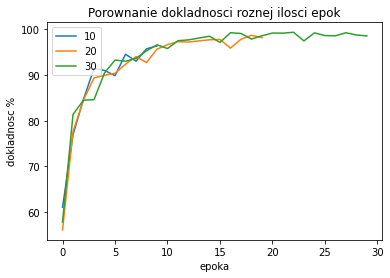

In [10]:
model_20 = Sequential()
model_20.add(Flatten(input_shape=(100, 100)))
model_20.add(Dense(128, activation='relu', name='fc1'))
model_20.add(Dense(64, activation='relu', name='fc2'))
model_20.add(Dense(4, activation='softmax', name='output'))
model_20.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_30 = Sequential()
model_30.add(Flatten(input_shape=(100, 100)))
model_30.add(Dense(128, activation='relu', name='fc1'))
model_30.add(Dense(64, activation='relu', name='fc2'))
model_30.add(Dense(4, activation='softmax', name='output'))
model_30.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_20 = model_20.fit(X_train, y_train, validation_split=0.33, epochs=20)
result_20 = model_20.evaluate(X_test, y_test)
print('\n\nDokladnosc dla 20 epok: ', result_20[1], '\n\n')

history_30 = model_30.fit(X_train, y_train, validation_split=0.33, epochs=30)
result_30 = model_30.evaluate(X_test, y_test)
print('\n\nDokladnosc dla 30 epok: ', result_30[1], '\n\n')


history_20.history['accuracy'] = np.array(history_20.history['accuracy'])*100
history_30.history['accuracy'] = np.array(history_30.history['accuracy'])*100

# porownanie dokladnosci roznej ilosci epok
plt.plot(history.history['accuracy'])
plt.plot(history_20.history['accuracy'])
plt.plot(history_30.history['accuracy'])
plt.title('Porownanie dokladnosci roznej ilosci epok')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['10', '20', '30'], loc='upper left')
plt.show()

Epoch 1/10
141/141 [==============================] - 1s 5ms/step - loss: 2.3076 - accuracy: 0.5807 - val_loss: 0.6384 - val_accuracy: 0.7048
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5434 - accuracy: 0.8093 - val_loss: 0.5151 - val_accuracy: 0.8291
Epoch 3/10
141/141 [==============================] - 1s 4ms/step - loss: 0.4947 - accuracy: 0.8284 - val_loss: 0.4366 - val_accuracy: 0.8594
Epoch 4/10
141/141 [==============================] - 1s 4ms/step - loss: 0.4084 - accuracy: 0.8679 - val_loss: 0.3954 - val_accuracy: 0.8608
Epoch 5/10
141/141 [==============================] - 1s 4ms/step - loss: 0.3555 - accuracy: 0.8971 - val_loss: 0.5631 - val_accuracy: 0.7202
Epoch 6/10
141/141 [==============================] - 1s 4ms/step - loss: 0.3246 - accuracy: 0.8986 - val_loss: 0.3343 - val_accuracy: 0.9222
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 0.2903 - accuracy: 0.9205 - val_loss: 0.2423 - val_accuracy: 0.9435
Epoch 

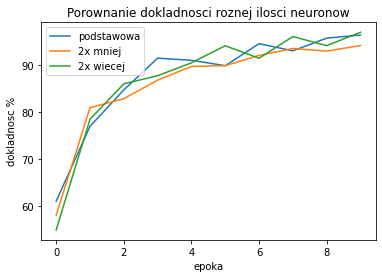

In [11]:
model4 = Sequential()
model4.add(Flatten(input_shape=(100, 100)))
model4.add(Dense(64, activation='relu', name='fc1'))
model4.add(Dense(32, activation='relu', name='fc2'))
model4.add(Dense(4, activation='softmax', name='output'))
model4.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, validation_split=0.33, epochs=10)
result4 = model4.evaluate(X_test, y_test)
print('\n\nDokladnosc dla 2x mniejszej ilosci neuronow: ', result4[1], '\n\n')

model5 = Sequential()
model5.add(Flatten(input_shape=(100, 100)))
model5.add(Dense(256, activation='relu', name='fc1'))
model5.add(Dense(128, activation='relu', name='fc2'))
model5.add(Dense(4, activation='softmax', name='output'))
model5.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history5 = model5.fit(X_train, y_train, validation_split=0.33, epochs=10)
result5 = model5.evaluate(X_test, y_test)
print('\n\nDokladnosc dla 2x wiekszej ilosci neuronow: ', result5[1], '\n\n')


history4.history['accuracy'] = np.array(history4.history['accuracy'])*100
history5.history['accuracy'] = np.array(history5.history['accuracy'])*100

# porownanie dokladnosci roznej ilosci neuronow
plt.plot(history.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.plot(history5.history['accuracy'])
plt.title('Porownanie dokladnosci roznej ilosci neuronow')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['podstawowa', '2x mniej', '2x wiecej'], loc='upper left')
plt.show()

Epoch 1/10
141/141 [==============================] - 1s 7ms/step - loss: 1.6824 - accuracy: 0.4385 - val_loss: 1.0093 - val_accuracy: 0.4846
Epoch 2/10
141/141 [==============================] - 1s 6ms/step - loss: 0.6500 - accuracy: 0.7221 - val_loss: 0.4861 - val_accuracy: 0.8386
Epoch 3/10
141/141 [==============================] - 1s 6ms/step - loss: 0.4408 - accuracy: 0.8304 - val_loss: 0.3793 - val_accuracy: 0.8666
Epoch 4/10
141/141 [==============================] - 1s 6ms/step - loss: 0.3530 - accuracy: 0.8768 - val_loss: 0.3244 - val_accuracy: 0.8766
Epoch 5/10
141/141 [==============================] - 1s 6ms/step - loss: 0.2543 - accuracy: 0.9066 - val_loss: 0.2366 - val_accuracy: 0.9127
Epoch 6/10
141/141 [==============================] - 1s 6ms/step - loss: 0.2501 - accuracy: 0.9046 - val_loss: 0.4907 - val_accuracy: 0.7486
Epoch 7/10
141/141 [==============================] - 1s 6ms/step - loss: 0.2025 - accuracy: 0.9218 - val_loss: 0.1412 - val_accuracy: 0.9507
Epoch 

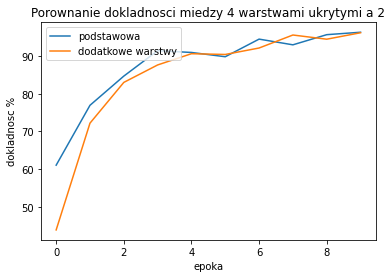

In [12]:
model6 = Sequential()
model6.add(Flatten(input_shape=(100, 100)))
model6.add(Dense(128, activation='relu', name='fc1'))
model6.add(Dense(96, activation='relu', name='fc2'))
model6.add(Dense(64, activation='relu', name='fc3'))
model6.add(Dense(32, activation='relu', name='fc4'))
model6.add(Dense(4, activation='softmax', name='output'))
model6.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history6 = model6.fit(X_train, y_train, validation_split=0.33, epochs=10)
result6 = model6.evaluate(X_test, y_test)
print('\n\nDokladnosc dla dodatkowych dwoch warstw: ', result6[1], '\n\n')


history6.history['accuracy'] = np.array(history6.history['accuracy'])*100

# porownanie dokladnosci z dodtkowymi warstwami ukrytymi
plt.plot(history.history['accuracy'])
plt.plot(history6.history['accuracy'])
plt.title('Porownanie dokladnosci miedzy 4 warstwami ukrytymi a 2')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['podstawowa', 'dodatkowe warstwy'], loc='upper left')
plt.show()

Epoch 1/30
141/141 [==============================] - 2s 10ms/step - loss: 3.0706 - accuracy: 0.5951 - val_loss: 0.5779 - val_accuracy: 0.7889
Epoch 2/30
141/141 [==============================] - 1s 8ms/step - loss: 0.5004 - accuracy: 0.7803 - val_loss: 0.4101 - val_accuracy: 0.7984
Epoch 3/30
141/141 [==============================] - 1s 8ms/step - loss: 0.3821 - accuracy: 0.8451 - val_loss: 0.3090 - val_accuracy: 0.8956
Epoch 4/30
141/141 [==============================] - 1s 8ms/step - loss: 0.3159 - accuracy: 0.8788 - val_loss: 0.2722 - val_accuracy: 0.8816
Epoch 5/30
141/141 [==============================] - 1s 8ms/step - loss: 0.2665 - accuracy: 0.8986 - val_loss: 0.2643 - val_accuracy: 0.9046
Epoch 6/30
141/141 [==============================] - 1s 8ms/step - loss: 0.2292 - accuracy: 0.9095 - val_loss: 0.2660 - val_accuracy: 0.8630
Epoch 7/30
141/141 [==============================] - 1s 8ms/step - loss: 0.1788 - accuracy: 0.9296 - val_loss: 0.3568 - val_accuracy: 0.8332
Epoch

<AxesSubplot:>

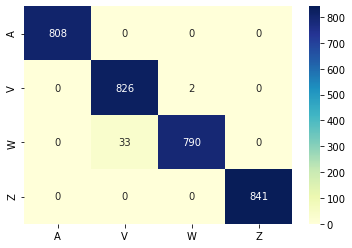

In [13]:
# najlepszy model zwykly
model_best = Sequential()
model_best.add(Flatten(input_shape=(100, 100)))
model_best.add(Dense(192, activation='relu', name='fc1'))
model_best.add(Dense(96, activation='relu', name='fc2'))
model_best.add(Dense(4, activation='softmax', name='output'))
model_best.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_org = time.time()
history_best = model_best.fit(X_train, y_train, validation_split=0.33, epochs=30)
end_org  = time.time()
result_best = model_best.evaluate(X_test, y_test)
predictions_best = model_best.predict(X_test)

print('\n\nStrata: ', result_best[0])
print('Dokladnosc: ', result_best[1])

pred_labels_best = np.argmax(predictions_best, axis = 1)
m_best = metrics.confusion_matrix(y_test, pred_labels_best)
sn.heatmap(m_best, annot=True, fmt="d", cmap="YlGnBu", xticklabels=y_labels, yticklabels=y_labels)

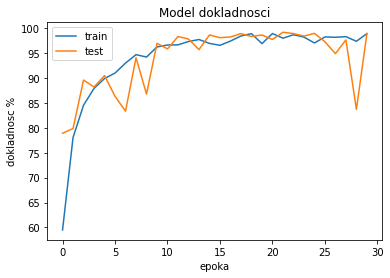

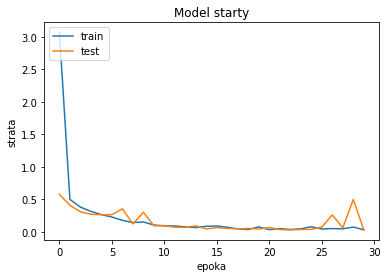

In [14]:
history_best.history['accuracy'] = np.array(history_best.history['accuracy'])*100
history_best.history['val_accuracy'] = np.array(history_best.history['val_accuracy'])*100

plt.plot(history_best.history['accuracy'])
plt.plot(history_best.history['val_accuracy'])
plt.title('Model dokladnosci')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title('Model starty')
plt.ylabel('strata')
plt.xlabel('epoka')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# stworzenie modelu z warstwami konwolucyjnymi
X_train_conv = X_train.reshape(-1, 100, 100, 1)
X_test_conv = X_test.reshape(-1, 100, 100, 1)
y_train_conv = y_train.reshape(-1, 1)
y_test_conv = y_test.reshape(-1, 1)

model_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation = 'relu', input_shape = (100, 100, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(4, activation='softmax', name='output')
])

Epoch 1/5
141/141 [==============================] - 8s 52ms/step - loss: 0.4194 - accuracy: 0.8235 - val_loss: 0.1067 - val_accuracy: 0.9715
Epoch 2/5
141/141 [==============================] - 7s 51ms/step - loss: 0.0271 - accuracy: 0.9964 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 3/5
141/141 [==============================] - 7s 50ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 4/5
141/141 [==============================] - 7s 49ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/5
104/104 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 1.0000


Strata:  0.0015018436824902892
Dokladnosc:  1.0


<AxesSubplot:>

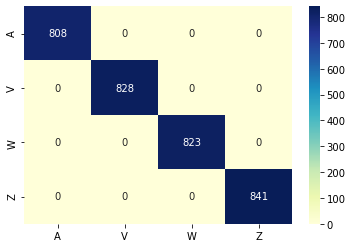

In [20]:
model_conv.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_conv = time.time()
history_conv = model_conv.fit(X_train_conv, y_train_conv, validation_split=0.33, epochs=5)
end_conv  = time.time()
result_conv = model_conv.evaluate(X_test_conv, y_test_conv)
predictions_conv = model_conv.predict(X_test_conv)

print('\n\nStrata: ', result_conv[0])
print('Dokladnosc: ', result_conv[1])

pred_labels_conv = np.argmax(predictions_conv, axis = 1)
m_conv = metrics.confusion_matrix(y_test_conv, pred_labels_conv)
sn.heatmap(m_conv, annot=True, fmt="d", cmap="YlGnBu", xticklabels=y_labels, yticklabels=y_labels)

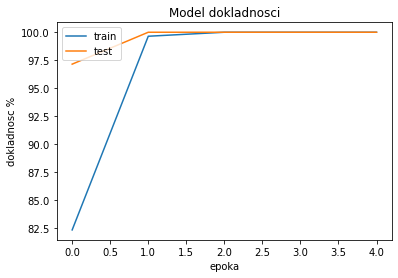

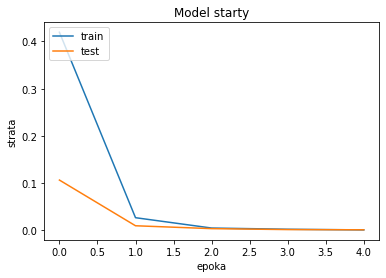

Czas modelu zwyklego:  36.23596930503845
Czas modelu konwolucyjnego:  35.875569581985474


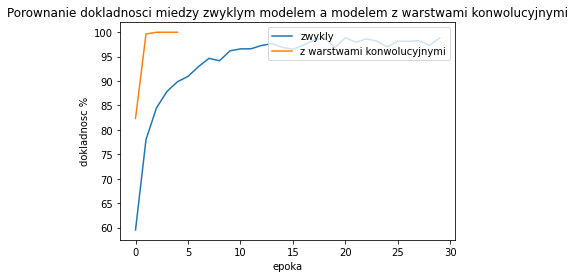

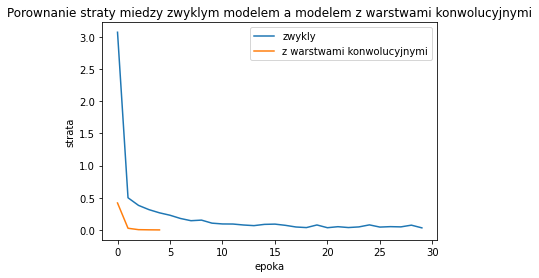

Strata modelu zwyklego:  0.03165321424603462
Strata modelu z warstwami konwolucyjnymi:  0.0015018436824902892 


Dokladnoscmodelu zwyklego:  0.989393949508667
Dokladnosc modelu z warstwami konwolucyjnymi:  1.0


In [21]:
history_conv.history['accuracy'] = np.array(history_conv.history['accuracy'])*100
history_conv.history['val_accuracy'] = np.array(history_conv.history['val_accuracy'])*100

plt.plot(history_conv.history['accuracy'])
plt.plot(history_conv.history['val_accuracy'])
plt.title('Model dokladnosci')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Model starty')
plt.ylabel('strata')
plt.xlabel('epoka')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# porownanie czasow uczenia sie modeli
print("Czas modelu zwyklego: ", end_org - start_org)
print("Czas modelu konwolucyjnego: ", end_conv - start_conv)


# porownanie dokladnosci miedzy zwyklym modelem a modelem z warstwami konwolucyjnymi
plt.plot(history_best.history['accuracy'])
plt.plot(history_conv.history['accuracy'])
plt.title('Porownanie dokladnosci miedzy zwyklym modelem a modelem z warstwami konwolucyjnymi')
plt.ylabel('dokladnosc %')
plt.xlabel('epoka')
plt.legend(['zwykly', 'z warstwami konwolucyjnymi'], loc='upper right')
plt.show()

plt.plot(history_best.history['loss'])
plt.plot(history_conv.history['loss'])
plt.title('Porownanie straty miedzy zwyklym modelem a modelem z warstwami konwolucyjnymi')
plt.ylabel('strata')
plt.xlabel('epoka')
plt.legend(['zwykly', 'z warstwami konwolucyjnymi'], loc='upper right')
plt.show()

print('Strata modelu zwyklego: ', result_best[0])
print('Strata modelu z warstwami konwolucyjnymi: ', result_conv[0], '\n\n')

print('Dokladnoscmodelu zwyklego: ', result_best[1])
print('Dokladnosc modelu z warstwami konwolucyjnymi: ', result_conv[1])